# Hold-out validation
In hold-out validation the dataset is split in two parts: one part is used during training and the other is used for testing the generalization capabilities of the model. This method has the advantage of being easy to implement. However, in hold-out validation the generalisation performance is evaluated with a single test, using a dataset partition that not necessarily represents the whole distribution of the whole dataset. Hence, it can produce some undesirable behaviours that lead to a wrong assessment of the performance of the model. In this notebook you are going to explore the behaviour of hold-out validation by simulating datasets with diverse degrees of complexity.

## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets

%matplotlib inline

## The dataset
This function creates a dataset with two classes in two dimensions. It has two parameters: the size of the dataset and the spread of each one of the classes. A high spread value makes both classes to superpose, making the classification more difficult.

In [2]:
def create_dataset(n, s):
    n1 = int(np.ceil(n / 2.0))
    n2 = int(np.floor(n / 2.0))
    x1 = np.random.normal(-1, s, n1)
    y1 = np.random.uniform(-1, 1,  n1)
    x2 = np.random.normal(1, s, n2)
    y2 = np.random.uniform(-1, 1, n2)
    return np.stack((np.concatenate((x1, x2)), np.concatenate((y1, y2)), np.concatenate((np.ones(n1), -1*np.ones(n2)))), 1)

In [3]:
def plot_dataset(s):
    dataset = create_dataset(200, s)
    pl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[int(cl > 0)] for cl in dataset[:,2]])
    pl.xlim(-3,3)
    pl.ylim(-1,1)
    pl.grid()

In [4]:
interact(plot_dataset, s=widgets.FloatSlider(value=0.1, min=0.1, max=1.0, step=0.01, description='Spread:',));

interactive(children=(FloatSlider(value=0.1, description='Spread:', max=1.0, min=0.1, step=0.01), Output()), _…

## The MLP

In [5]:
import mlp_backprop_momentum as mlp

## Exploring hold-out validation
The following function splits the dataset in two parts. The parameter `train_test_ratio` controls the proportions of the partitions.

In [6]:
def split_dataset(dataset, train_test_ratio = 0.8):
    index_all = np.arange(dataset.shape[0])
    np.random.shuffle(index_all)
    break_point = int(train_test_ratio * len(index_all))
    index_train = index_all[0:break_point]
    index_test = index_all[break_point:]
    dataset_train = dataset[index_train,:]
    dataset_test = dataset[index_test,:]
    return (dataset_train, dataset_test)

### Experiment
In this experiment we create datasets with different degrees of complexity and we test the behaviour of hold-out validation with each one of them. For each dataset, we split the dataset several times, which generates different partitions training/testing. We also initializes the neural networks several times with each partition in order to be sure that the results are not a special case of a lucky initialization.

In [11]:
N_INITS = 2
N_SPLITS = 10
DATASET_SIZE = 200
EPOCHS = 100
N_NEURONS = 2
LEARNING_RATE = 0.001
MOMENTUM = 0.7
TRAIN_TEST_RATIO = 0.8
DATA_PARAMS = np.arange(0.4, 0.71, 0.1)

In [12]:
MSE_train = np.zeros((len(DATA_PARAMS), N_SPLITS * N_INITS, EPOCHS))
MSE_test = np.zeros((len(DATA_PARAMS), N_SPLITS * N_INITS, EPOCHS))
MSE_test_last = np.zeros((len(DATA_PARAMS), N_SPLITS * N_INITS))
for p, s in enumerate(DATA_PARAMS):                                     # looping the set of parameters
    print('Testing dataset with variance:', s)

    dataset = create_dataset(DATASET_SIZE, s)
    
    for d in np.arange(N_SPLITS):                                       # looping the splits
        dataset_train, dataset_test = split_dataset(dataset, TRAIN_TEST_RATIO)
    
        for i in np.arange(N_INITS):                                    # looping the initializations
            sys.stdout.write('.')
            nn = mlp.MLP([2,N_NEURONS,1], 'tanh')
            input_data = dataset_train[:,0:nn.n_inputs]
            output_data = dataset_train[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
            input_data_test = dataset_test[:,0:nn.n_inputs]
            output_data_test = dataset_test[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]

            t = (d * N_INITS) + i
            MSE_train[p,t,:], MSE_test[p,t,:] = nn.fit((input_data, output_data), 
                                                       (input_data_test, output_data_test),
                                                       learning_rate=LEARNING_RATE, momentum=MOMENTUM, epochs=EPOCHS)
            MSE_test_last[p,t] = MSE_test[p,t,-1]
    print(N_INITS * N_SPLITS, 'tests done')

Testing dataset with variance: 0.4
....................20 tests done
Testing dataset with variance: 0.5
....................20 tests done
Testing dataset with variance: 0.6
....................20 tests done
Testing dataset with variance: 0.7
....................20 tests done


Plotting the resulting MSE, we can observe that each partition, i.e., each run of hold-out validation, generates different values of model error. For the same dataset, running hold-out validation several times does not generate coherent assessments of model error.

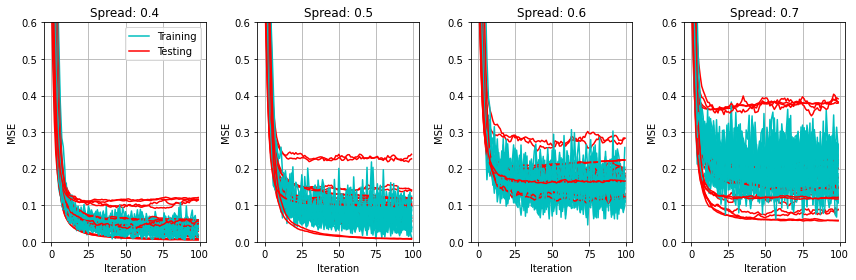

In [15]:
MAX_COL = 4
n_rows = np.ceil(float(MSE_train.shape[0]) / MAX_COL)
pl.figure(figsize=(12, 4 * n_rows))
for d in range(MSE_train.shape[0]):
    pl.subplot(int(n_rows), MAX_COL, d+1)
    for r in range(MSE_train.shape[1]):
        pl.plot(MSE_train[d,r,:], c='c', label='Training')
        pl.plot(MSE_test[d,r,:], c='r', label='Testing')
        if d == 0 and r == 0:
            pl.legend()
    pl.ylim(0, 0.6)
    pl.ylabel('MSE')
    pl.xlabel('Iteration')
    pl.title('Spread: '+str(DATA_PARAMS[d]))
    pl.grid()
pl.tight_layout()

Observe that the red curves end (last iteration) at different values of MSE. Different partitions are more or less easy to learn. Some data partitions are memorized by the neural networ: which means a low training error and a high testing error.

In [ ]:
pl.boxplot(MSE_test_last.T, positions=DATA_PARAMS, widths=0.05)
for c in np.arange(MSE_test_last.shape[1]):
    pl.scatter(DATA_PARAMS, MSE_test_last[:,c], s=10, c='g', marker='x')

pl.xlim(np.min(DATA_PARAMS)-0.1, np.max(DATA_PARAMS)+0.1)
pl.xlabel('Spread')
pl.ylabel('MSE')
pl.title('Several runs of hold-out validation')
pl.grid()